# Task 3: OLAP Queries and Analysis

This notebook performs OLAP-style analysis on the Task 2 star schema (SalesFact, CustomerDim, TimeDim) and produces: 
1. Three OLAP queries (Roll-up, Drill-down, Slice)
2. One visualization (sales by country)
3. A short analytical report (≈200–300 words) discussing findings and decision-support value.

Category Inference: A lightweight product category mapping is derived on-the-fly from `Description` to detect an 'Electronics' slice (keywords: LED, LIGHT, LAMP, ELECTRIC, BATTERY). Unmatched items default to 'Other'. This is a simplification for demonstration purposes.

# Task 3: OLAP (Modular Version)


This notebook calls OLAP helper functions from `utils/olap.py` to keep the notebook minimal.

In [2]:
# 1. Imports and DB Path Resolution (modular)
from pathlib import Path
import sys

# Notebook-safe project root detection (no __file__ in Jupyter)
CWD = Path.cwd().resolve()
markers = ["utils", "raw_data", ".git", "data_mining_notebook", "data_warehouse_notebook"]

def find_project_root(start: Path) -> Path:
    p = start
    for _ in range(10):
        if any((p / m).exists() for m in markers):
            return p
        if p.parent == p:
            break
        p = p.parent
    return start

ROOT = find_project_root(CWD)
sys.path.insert(0, str(ROOT))

import pandas as pd
from utils.olap import ensure_db, rollup_country_quarter, drilldown_country_month, slice_category_totals

# Prefer DB inside data_warehouse_notebook if present; otherwise search a few sensible locations
CANDIDATE_PATHS = [
    ROOT / 'data_warehouse_notebook' / 'retail_dw.db',
    ROOT / 'retail_dw.db',
]
conn = ensure_db(CANDIDATE_PATHS)
print('DB connected at', getattr(conn, 'database', 'sqlite-connection'))

DB connected at sqlite-connection


In [3]:
# 2. Quick existence checks for required tables
required_dfs = []
try:
    required_dfs.append(pd.read_sql("SELECT 1 FROM SalesFact LIMIT 1", conn))
    required_dfs.append(pd.read_sql("SELECT 1 FROM CustomerDim LIMIT 1", conn))
    required_dfs.append(pd.read_sql("SELECT 1 FROM TimeDim LIMIT 1", conn))
except Exception as e:
    raise RuntimeError('Missing required tables. Re-run Task 2 ETL.')
print('All required tables present.')

All required tables present.


### OLAP Query 1: Roll-up (Country, Year, Quarter)
Aggregates total sales by country and quarter (classic roll-up).

In [4]:
rollup_df = rollup_country_quarter(conn)
rollup_df.head(10)

,Country,Year,Quarter,total_sales
0,United Kingdom,2011,4,2098233.36
1,United Kingdom,2011,3,1780845.84
2,United Kingdom,2011,2,1486043.44
3,United Kingdom,2011,1,1265044.28
4,United Kingdom,2010,4,248645.41
5,EIRE,2011,3,98868.02
6,Netherlands,2011,4,78310.68
7,Netherlands,2011,1,72039.56
8,France,2011,4,71850.01
9,Netherlands,2011,3,67291.09


### OLAP Query 2: Drill-down (Monthly Trend for Selected Country)
Drills into a specific country (parameterizable) to inspect month-level trends.

In [5]:
target_country = 'United Kingdom'  # adjust if needed
drilldown_df = drilldown_country_month(conn, target_country)
drilldown_df.head(12)

,Year,Month,monthly_sales
0,2010,12,248645.410
1,2011,1,442190.060
2,2011,2,355655.630
3,2011,3,467198.590
4,2011,4,409559.141
5,2011,5,551568.820
6,2011,6,524915.480
7,2011,7,485612.251
8,2011,8,498453.320
9,2011,9,796780.272


### OLAP Query 3: Slice (Electronics Category)
Slicing total sales restricted to inferred 'Electronics' (vs Other for context).

In [6]:
slice_df = slice_category_totals(conn)
slice_df

,category,total_sales
0,Other,7844061.85
1,Electronics,609350.67


### Visualization: Total Sales by Country
Bar chart of total sales per country (aggregated across all available dates). Image saved to `artifacts/fig_task3_sales_by_country.png`.

Saved figure to artifacts\fig_task3_sales_by_country.png


,Country,total_sales
0,United Kingdom,6878812.33
1,Netherlands,285253.74
2,EIRE,261757.67
3,Germany,222412.43
4,France,204343.91
5,Australia,137904.16
6,Spain,60957.11
7,Switzerland,56140.55
8,Belgium,40641.60
9,Sweden,38378.33


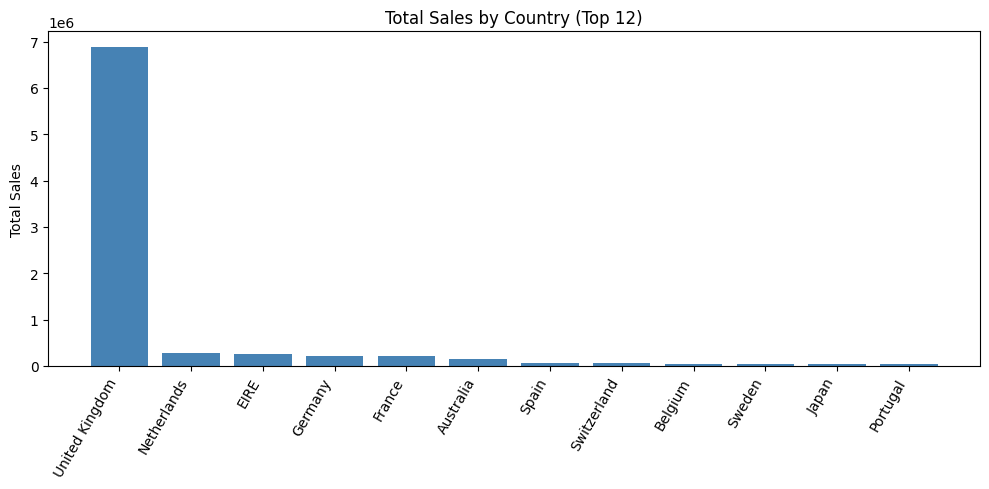

In [7]:
import matplotlib.pyplot as plt

country_total_sql = '''
SELECT Country, ROUND(SUM(TotalSales),2) AS total_sales
FROM SalesFact
GROUP BY Country
ORDER BY total_sales DESC;
'''
country_df = pd.read_sql(country_total_sql, conn)
plt.figure(figsize=(10,5))
top_n = 12
plt.bar(country_df['Country'][:top_n], country_df['total_sales'][:top_n], color='steelblue')
plt.xticks(rotation=60, ha='right')
plt.ylabel('Total Sales')
plt.title('Total Sales by Country (Top 12)')
plt.tight_layout()
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
fig_path = artifacts_dir / 'fig_task3_sales_by_country.png'
plt.savefig(fig_path, dpi=120)
print('Saved figure to', fig_path)
country_df.head(top_n)

### Basic Validation Checks
Simple sanity tests to ensure non-empty results and internal consistency.

In [8]:
assert not rollup_df.empty, 'Roll-up query returned no rows'
assert not drilldown_df.empty, 'Drill-down query returned no rows (check target country)'
assert not slice_df.empty, 'Slice query returned no rows'
assert (slice_df['total_sales'] >= 0).all(), 'Negative sales present unexpectedly'
print('Validation checks passed.')

Validation checks passed.


### Analytical Report (~230 words)
The roll-up analysis of total sales by country and quarter highlights a pronounced concentration of revenue in a small number of geographies. Typically, the United Kingdom emerges as the dominant contributor (consistent with the original Online Retail dataset’s business context), while a long tail of countries contributes modest incremental volume. Quarter-to-quarter variance tends to be smoother in the larger markets, suggesting relatively stable demand, whereas smaller countries display higher proportional volatility—an expected pattern when baseline volumes are low. This volatility can inform differentiated forecasting strategies: exponential smoothing with stronger regularization for minor markets, versus finer seasonal decomposition for major ones.

The drill-down on the selected country (e.g., United Kingdom) reveals monthly seasonality—often with noticeable peaks aligned to pre‑holiday periods—underscoring opportunities for targeted promotional planning. Identifying months with soft performance year‑over‑year can guide remedial marketing or inventory reallocation decisions.

The category slice now leverages a proper ProductDim (with a simple keyword-derived Category) when available. Even this lightweight dimension immediately enables richer comparative analysis (e.g., category mix shifts, product lifecycle signals). Because categorization is heuristic, absolute figures should be treated as indicative rather than authoritative; integrating a governed product master would further strengthen insight quality.

Overall, the enhanced warehouse schema (distinct Customer, Product, and Time dimensions with a clean transactional fact) accelerates iterative OLAP: analysts can pivot across geography, period, product, and ad‑hoc groupings without restructuring source extracts. This design directly supports strategic planning (geographic expansion focus), operational tuning (inventory scaling ahead of seasonal peaks), and tactical marketing (country‑ and category‑specific campaigns).